In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx
 
def read_article(file_name):
    file = open(file_name, "r")
    filedata = file.readlines()
    article = filedata[0].split(". ")
    sentences = []

    for sentence in article:
        print(sentence)
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    sentences.pop() 
    
    return sentences

def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)
 
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix


def generate_summary(file_name, top_n=5):
    nltk.download("stopwords")
    stop_words = stopwords.words('english')
    summarize_text = []

    # Step 1 - Read text anc split it
    sentences =  read_article(file_name)

    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)

    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph)

    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
    print("\n\nIndexes of top ranked_sentence order are ", ranked_sentence)    

    for i in range(top_n):
      summarize_text.append(" ".join(ranked_sentence[i][1]))

    # Step 5 - Offcourse, output the summarize texr
    print("\n\nSummarize Text: \n", ". ".join(summarize_text))

In [2]:
generate_summary( "test.txt", 3)

Human coronaviruses (HCoVs) cause mild to severe respiratory diseases.Six types of HCoVs have been discovered; the most recent one termed the Middle East respiratory syndrome coronavirus (MERS-CoV)
The aim of this study is to monitor the circulation of HCoV types in the population during 2015-2016 in Israel
HCoVs were detected by real-time PCR analysis in 1910 respiratory samples; collected from influenza-like illness (ILI) patients during the winter sentinel influenza survey across Israel
Moreover; 195 HCoV-positive samples from hospitalized patients were detected during one year at Soroka University Medical Center
While no MERS-CoV infections were detected; 10.36% of patients in the survey were infected with HCoV-OC43 (43.43%); hcov-nl63 (44.95%); and HCoV-229E (11.62%) viruses
The HCoVs were shown to co-circulate with respiratory syncytial virus (RSV) and to appear prior to influenza virus infections
HCoV clinical symptoms were more severe than those of RSV infections but milder tha

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/swastik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# !wget https://raw.githubusercontent.com/thushv89/attention_keras/master/layers/attention.py

In [4]:
from attention import AttentionLayer

In [5]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [6]:
data=pd.read_csv("Reviews.csv", nrows=100000)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [7]:
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


In [9]:
data['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [10]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [11]:
data['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [12]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [13]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [14]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

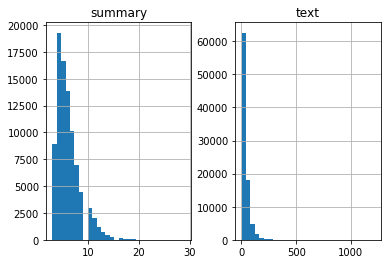

In [15]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [16]:
max_len_text=80 
max_len_summary=10

In [17]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.3,random_state=0,shuffle=True) 

In [18]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [19]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [20]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      22771500    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [21]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [22]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [23]:
history=model.fit([x_tr, y_tr[:, :-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:] ,epochs=10, batch_size=256, validation_data=([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]))

Train on 61846 samples, validate on 26506 samples
Epoch 1/10
61846/61846 [==============================] - 298s 5ms/sample - loss: 3.0971 - val_loss: 2.7675
Epoch 2/10
61846/61846 [==============================] - 291s 5ms/sample - loss: 2.6391 - val_loss: 2.4402
Epoch 3/10
61846/61846 [==============================] - 290s 5ms/sample - loss: 2.4379 - val_loss: 2.3365
Epoch 4/10
61846/61846 [==============================] - 290s 5ms/sample - loss: 2.3094 - val_loss: 2.2675
Epoch 5/10
61846/61846 [==============================] - 290s 5ms/sample - loss: 2.2051 - val_loss: 2.2288
Epoch 6/10
61846/61846 [==============================] - 289s 5ms/sample - loss: 2.1103 - val_loss: 2.2025
Epoch 7/10
61846/61846 [==============================] - 289s 5ms/sample - loss: 2.0193 - val_loss: 2.1927
Epoch 8/10
61846/61846 [==============================] - 289s 5ms/sample - loss: 1.9287 - val_loss: 2.1877
Epoch 9/10
61846/61846 [==============================] - 289s 5ms/sample - loss: 1.83

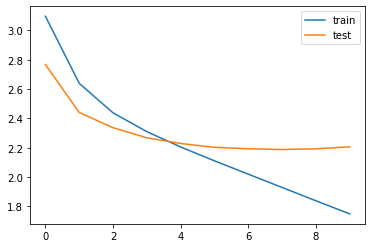

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [25]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [26]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [33]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         print(sampled_token_index)
        if sampled_token_index == 0:
            return decoded_sentence
        sampled_token = reverse_target_word_index[sampled_token_index]
#         print(sampled_token, decoded_sentence)

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [34]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [36]:
for i in range(len(x_val[100])):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
    print("\n")

Review: ordered salmon thursday january received january salmon delicious wooden box nice design used store items future 
Original summary: smokehouse smoked salmon 
Predicted summary:  great for baking


Review: drank cold could pleased coffee high quality arabica always notice coffee arabica robusta sweet without sweet mean cannot compare major bottled coffee brand reason alone keep fridge work offer people without looking like pushing calories along caffeine long time would stock highly sweetened coffee beverages fridge work noticed people stopped consuming happened around time lost interest level sweetness recommend drink prefer lower level sugar old school arabica coffee types 
Original summary: it was perfect little sweet without being too sweet 
Predicted summary:  great coffee for espresso lovers


Review: variety granola one ranks top favorites crunch granola coconut main taste sweet overly eat snack craving something fills fast satisfies sugar cravings 
Original summary: grea

Predicted summary:  great value


Review: long time keurig user lifetime coffee drinker breakfast blend part plain cup coffee light smooth slight bitterness end still prefer donut shop light everyday coffee choice wanted try box green mountain probably purchase one house stopped said thats great cup coffee plain blah probably struggle finish box honestly 
Original summary: breakfast blend nothing special 
Predicted summary:  good coffee


Review: even though sealed individual packages nice seems like retain freshness sticks got like shoe leather little taste would purchase think flavor since vaccummed sealed freshness also sticks get hard 
Original summary: needs to freshness longer gets like shoe leather 
Predicted summary:  not good


Review: actually delivered two lbs bags box added bonus two spoons came box sure actually use overall favorite salt getting pound bags decided move lbs save money 
Original summary: good salt 
Predicted summary:  great taste and texture


Review: brewin

Predicted summary:  good but


Review: hour energy like dream come true working spouse manager feet thirteen hours day gets extremely exhausting agreed receiving sample smiley online exchange opinions first line try impressed contained along folic acid small amount caffeine husband tried hour energy full day work hopes able stay awake watch baseball game surprized give hours energy hour energy also dietary supplement health education act fda 
Original summary: the energy booster with no sugar only calories 
Predicted summary:  works well with no problems


Review: happy recieved order cookies melted good product word advise buy products summer time melt 
Original summary: bahlsen cookies 
Predicted summary:  broken cookies


Review: agree reviewer think cereal marshmallows gross never liked teddy grahams much anyway 
Original summary: fake and gross 
Predicted summary:  not too sweet


Review: regular grocery store honey dark deep molasses flavor delicious anything would add honey like